<class 'pandas.core.frame.DataFrame'>
Index: 1596 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1596 non-null   float64
 1   volatile acidity      1596 non-null   float64
 2   citric acid           1596 non-null   float64
 3   residual sugar        1596 non-null   float64
 4   chlorides             1596 non-null   float64
 5   free sulfur dioxide   1596 non-null   float64
 6   total sulfur dioxide  1596 non-null   float64
 7   density               1596 non-null   float64
 8   pH                    1596 non-null   float64
 9   sulphates             1596 non-null   float64
 10  alcohol               1596 non-null   float64
 11  quality               1596 non-null   float64
dtypes: float64(12)
memory usage: 162.1 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1596.000000       1596.000000  1596.000000     1596.0000

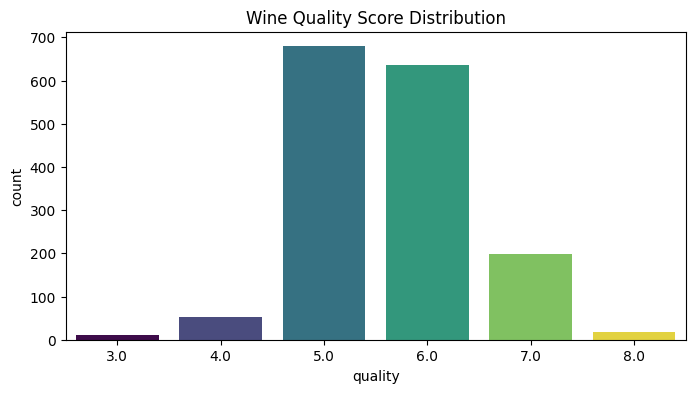

Detected 80 outliers (potentially excellent or poor wines).


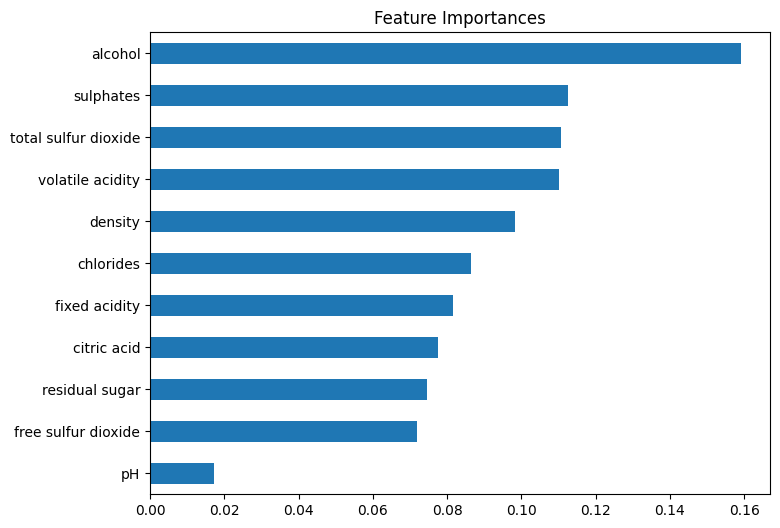

Selected features: ['volatile acidity', 'chlorides', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']
Accuracy: 0.6875
Classification Report:
               precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00        11
         5.0       0.71      0.81      0.75       136
         6.0       0.68      0.68      0.68       128
         7.0       0.69      0.55      0.61        40
         8.0       0.50      0.33      0.40         3

    accuracy                           0.69       320
   macro avg       0.43      0.40      0.41       320
weighted avg       0.66      0.69      0.67       320

Confusion Matrix:
 [[  0   1   1   0   0   0]
 [  0   0   8   3   0   0]
 [  0   1 110  22   3   0]
 [  0   0  35  87   6   0]
 [  0   0   2  15  22   1]
 [  0   0   0   1   1   1]]


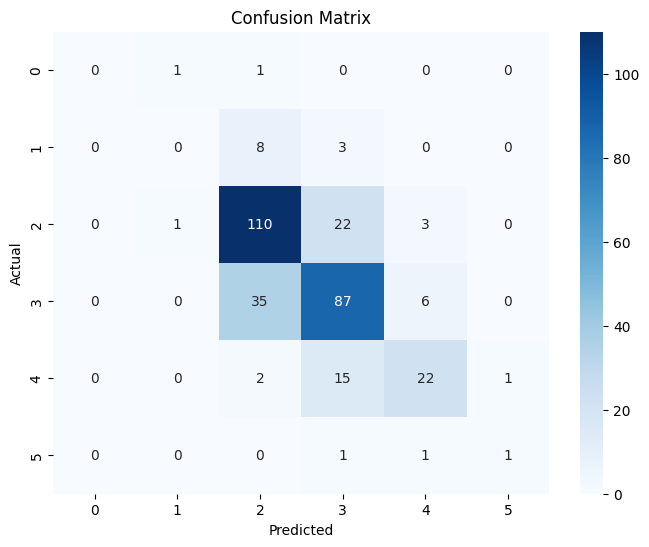

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Load your CSV (replace with your file path if needed)
df = pd.read_csv('major.csv')

# 2. Remove rows where 'quality' (target) is NaN
df = df.dropna(subset=['quality'])

# 3. Remove rows with any NaN in features
feature_cols = [col for col in df.columns if col != 'quality']
df = df.dropna(subset=feature_cols)

# 4. Data Exploration
print(df.info())
print(df.describe())
print(df['quality'].value_counts())

# 5. Visualize class balance (seaborn fix)
plt.figure(figsize=(8,4))
sns.countplot(x='quality', data=df, hue='quality', palette='viridis', legend=False)
plt.title('Wine Quality Score Distribution')
plt.show()

# 6. Outlier Detection (for excellent/poor wines)
outlier_detector = IsolationForest(contamination=0.05, random_state=42)
df['outlier'] = outlier_detector.fit_predict(df[feature_cols])
outliers = df[df['outlier'] == -1]
print(f"Detected {len(outliers)} outliers (potentially excellent or poor wines).")

# 7. Feature Selection using Random Forest
X = df[feature_cols]
y = df['quality']

# Split data (always use DataFrame to keep feature names)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit Random Forest for feature importance (with feature names)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Show feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
plt.figure(figsize=(8,6))
importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.show()

# Fit SelectFromModel directly (NO prefit=True)
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_features = X.columns[selector.get_support()]
print("Selected features:", list(selected_features))

# 8. Train classifier on selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)
y_pred = rf_selected.predict(X_test_selected)

# 9. Evaluation (with warning suppressed)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 10. Visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
